# X-ray 이미지로 폐렴 진단하기
- X-ray 이미지로 정상인지, 폐렴인지 분류해보자.

# step1) 사용할 패키지 및 변수

In [52]:
import os, re
import random, math
import numpy as np
import tensorflow as tf

# 학습 history 저장
import joblib

# 모델 및 학습 결과 시각화
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]
res = 180

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/enode11')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel/enode11


# step2) 데이터 가져오기

## 2-1. 이미지 개수 확인
- 검증용 이미지 개수가 너무 적다..

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


## 2-2. train, validation 데이터 목록 모은 후 재분리
- validation 데이터 개수를 늘리기 위해 두 데이터 목록을 모은 뒤에 다시 나눈다.
- 데이터를 셔플링 한 다음 다시 8:2 비율로 나누자.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


## 2-3. 정상 이미지, 폐렴 이미지 구분
- 정상인 이미지와 폐렴 환자의 이미지는 다른 경로에 저장되어있다.

    📂chest_xray
      └📂data
          └📂train
              └📁NORMAL
              └📁PNEUMONIA
          └📁test
              └📁NORMAL
              └📁PNEUMONIA
          └📁val
              └📁NORMAL
              └📁PNEUMONIA

In [5]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/enode11/chest_xray/data/train/PNEUMONIA/person541_bacteria_2274.jpeg
Pneumonia image path
/aiffel/aiffel/enode11/chest_xray/data/train/PNEUMONIA/person1321_bacteria_3358.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1084
Pneumonia images count in training set: 3101


## 2-4. tf.data 인스턴스 생성
- 배치 작업을 효율적으로 처리할 수 있게 도와준다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


## 2-5. 라벨 데이터 생성 도우미 함수
- 따로 이미지에 라벨 데이터가 없는 상황.
- 파일 경로에 포함된 라벨을 이용해 라벨 데이터 생성

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [ ]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img): # 이미지 크기가 제각각이면 효율적으로 적재 불가
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

# step8) Data Augmentation 시도
- 기존 데이터를 회전, 비트 시프트, 확대/축소, 대비 강조해서 데이터를 증강해보자.

## 8-1. 데이터 증강 도우미 함수
- def `apply_mat(image, transform_mat)` : 회전 정도를 이미지에 적용시켜 주는 함수
- def `random_rotate(image)` : 이미지를 회전할 각도를 계산하는 하는 함수
- def `random_shift(image)`: 이미지를 비트 시프트 하는 함수
- def `random_zoom(image)` : 이미지를 확대,축소 하는 함수
- def `random_contrast(image, max_val=1, min_val=-1)` : 이미지 대비(콘트라스트) 정도를 바꾸는 함수

In [11]:
def apply_mat(image, transform_mat):
    
    # move origin to image midpoint
    # get lists of rows and cols as list
    rows = tf.range(-res/2, res/2)
    cols = tf.range(-res/2, res/2)
    
    # compute cartesian product rows x cols
    # tf.repeat repeats each tensor element
    # tf.tile replicates whole tensor
    # rows are repeated as the number of columns
    coords = tf.stack([tf.repeat(rows, len(cols)), 
                       tf.tile(cols, [len(rows)])], axis=1)
    
    trn_coords = tf.transpose(tf.linalg.matmul(transform_mat,
                                            tf.transpose(coords)))
    
    # add offsets to move origin to topleft
    offset = tf.stack([tf.repeat(res/2, len(trn_coords)), 
                       tf.repeat(res/2, len(trn_coords))], axis=1)
    
    trn_coords = tf.math.add(trn_coords, offset)
    trn_coords = tf.clip_by_value(trn_coords, 0, res-1)
    
    # get transformed pixels
    trn_pixels = tf.gather_nd(image, tf.cast(trn_coords, tf.int32))    
    trn_image = tf.reshape(trn_pixels, [res,res,3])
    
    return trn_image

In [12]:
theta_low = -0.3
theta_high = 0.3
hrz_shift = 40
ver_shift = 40
size_low = 0.8
size_high = 1.3
cont_low = 0.7
cont_high = 1.3

def random_rotate(image):
    # tf.math.cos and tf.math.sin expect radian input
    theta = tf.random.uniform([], minval=theta_low,
                                  maxval=theta_high,
                                  dtype=tf.float32)
    # rotation matrix
    transform_mat = tf.convert_to_tensor([[tf.math.cos(theta),
                                          -tf.math.sin(theta)],
                                          [tf.math.sin(theta),
                                           tf.math.cos(theta)]])

    return apply_mat(image, transform_mat)

def random_shift(image):
    h1 = tf.random.uniform([], minval=0, maxval=hrz_shift, dtype=tf.int32)
    h2 = tf.random.uniform([], minval=0, maxval=hrz_shift, dtype=tf.int32)    
    w1 = tf.random.uniform([], minval=0, maxval=ver_shift, dtype=tf.int32)    
    w2 = tf.random.uniform([], minval=0, maxval=ver_shift, dtype=tf.int32)
    trn_image = tf.image.crop_to_bounding_box(image, h1, w1,
                                              res-h1-h2, res-w1-w2)
    trn_image = tf.image.resize(trn_image, size=IMAGE_SIZE,
                                            method="bicubic")  
    return tf.reshape(trn_image, IMAGE_SIZE.append(3))

def random_zoom(image):
    size_factor = tf.random.uniform([], minval=size_low,
                                        maxval=size_high,
                                        dtype=tf.float32)
    r_size = tf.cast(size_factor*res, tf.int32)
    s_image = tf.image.resize(image, size=[r_size,r_size],
                                          method="bicubic")
    trn_image = tf.image.resize_with_crop_or_pad(s_image, res, res)    
    return tf.reshape(trn_image, [res, res, 3])

def random_contrast(image, max_val=1, min_val=-1):
    cont_factor = tf.random.uniform([], minval=cont_low,
                                        maxval=cont_high,
                                        dtype=tf.float32)

    trn_image = tf.image.adjust_contrast(image, cont_factor)  
    trn_image = tf.minimum(trn_image, max_val)
    trn_image = tf.maximum(trn_image, min_val)
    return tf.reshape(trn_image, [res, res, 3])

## 8-2. 이미지 증강 함수
- 앞서 정의한 함수들을 랜덤으로 골라서 이미지에 적용한다.
- 배치 도우미 함수 `prepare_for_training`에 추가한다.

In [10]:
# 이미지 증강을 시도합니다.
def augment(image,label):
    functions = [random_rotate, random_shift, random_zoom, random_contrast]
    trn_image = random.choice(functions)(image)      
    return trn_image, label  

## 2-6.  train, validation 데이터셋 생성
- 이전 num_parallel_cells 파라미터에서 초기화한 `AUTOTUNE` 활용시 더욱 빠르게 데이터 처리 가능

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

### 전처리 및 사이즈 변환 잘되었나 확인
- 데이터셋에서 `take(1)` 하나만 가져와 

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


## 2-7. test 데이터셋 생성

In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## 2-8. 학습을 위한 데이터 배치 도우미 함수
- 기존의 배치 함수에 `agument()`를 적용했다.

In [16]:
# 학습을 효율적으로 적용할 수 있게 데이터 변환
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # 버퍼에서 무작위로 균일하게 다음 요소 선택
    ds = ds.map(augment,
               num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정크기 버퍼 사용
    # 여러 epoch 진행하면서 데이터셋 재사용가능하게 데이터 개수 맞추기
    ds = ds.repeat()
    # 정해진 BATCH_SIZE 만큼 나누기
    ds = ds.batch(BATCH_SIZE)
    # 학습 데이터 나눠서 읽기
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# step3) 데이터 시각화
- 만든 데이터셋 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

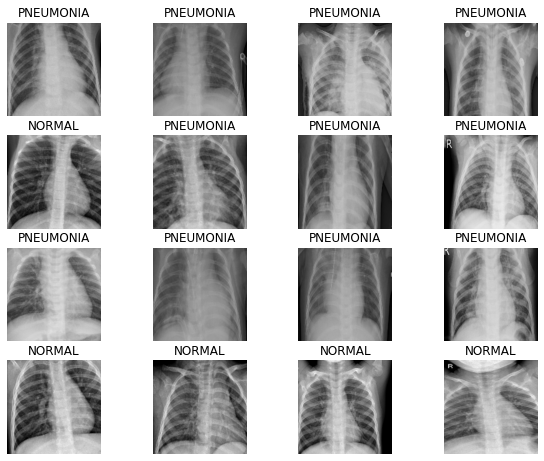

In [20]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

- 아래 증강 전 데이터에 비해 정중앙에 있지 않은 데이터도 많다.
- 일정 부분 회전된 데이터도 보인다.
- 확대로 인해 여백이 많이 사라진 데이터도 보인다.

![증강 전 이미지](pneumonia/before_data.png)

# step4) CNN 모델링
- 전형적인 CNN과 달리 `BatchNormalization`과 `Dropout`기법이 동시에 사용한다.

In [21]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [22]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [23]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# step5) 데이터 불균형 처리
- 특정 라벨의 데이터만 많을 경우 학습 효과가 좋지 않다.
- train set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치 부여한다.
- `keras.model.fit()`에서 `class_weight`로 클래스별 가중치 설정 가능하다.
- 참고 : [딥러닝에서 클래스 불균형 다루기](https://3months.tistory.com/414)

- `weight_for_0`은 `Normal` 이미지에 사용할 weight를 의미
- `weight_for_1`은 `Pneumonia` 이미지에 사용할 weight를 의미
- weight들은 전체 데이터 건수에 반비례 하도록 설정한다.

In [24]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


# step6) 모델 훈련
- 두 개의 라벨이니 손실 함수로 `binary_cross_entropy`를 사용한다.
- optimizer : `adam`
- 성능 평가 지표 : `accuracy`, `precision`, `recall`

In [25]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

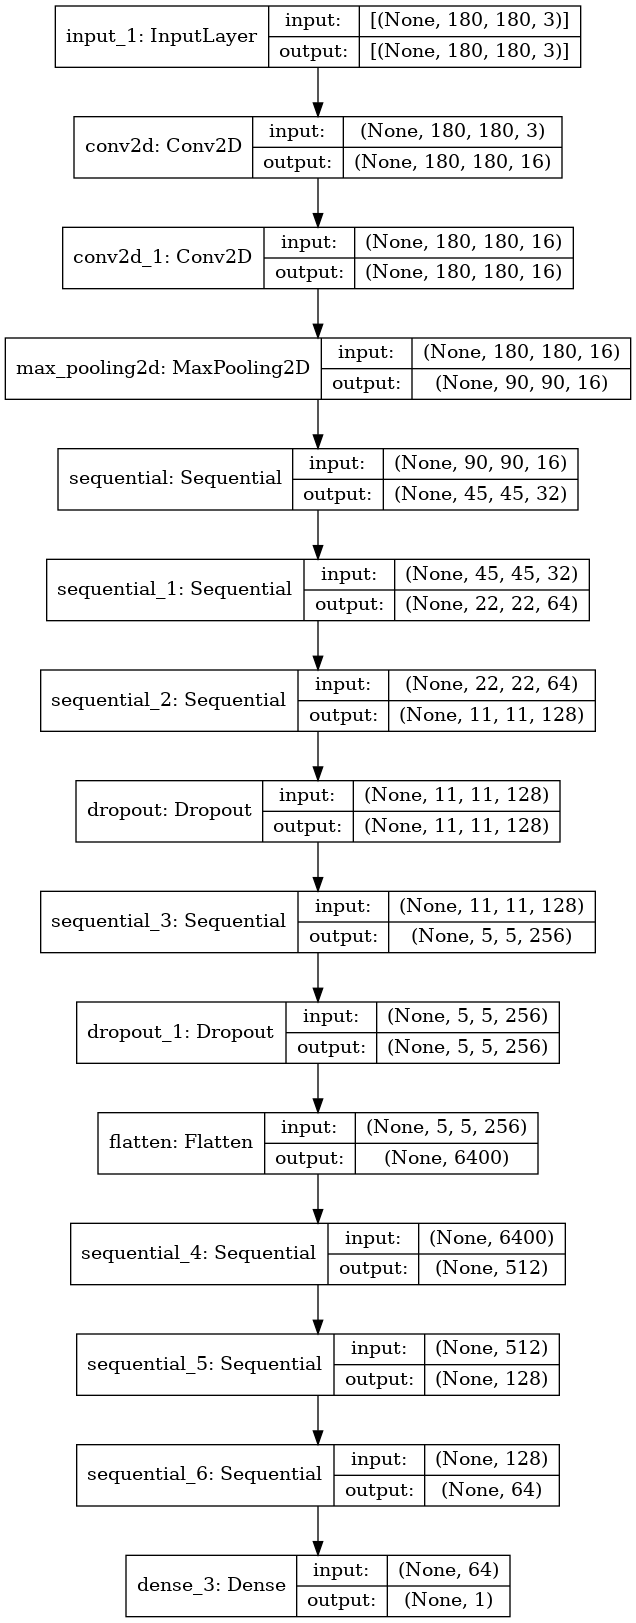

In [53]:
plot_model(model, show_shapes=True, to_file='augment.png')

In [50]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 39s 130ms/step - loss: 0.1749 - accuracy: 0.9301 - precision: 0.9798 - recall: 0.9247 - val_loss: 0.1527 - val_accuracy: 0.9394 - val_precision: 0.9917 - val_recall: 0.9267
Epoch 2/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1923 - accuracy: 0.9279 - precision: 0.9801 - recall: 0.9215 - val_loss: 0.3466 - val_accuracy: 0.8538 - val_precision: 0.9984 - val_recall: 0.8059
Epoch 3/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1813 - accuracy: 0.9294 - precision: 0.9811 - recall: 0.9224 - val_loss: 0.3951 - val_accuracy: 0.8365 - val_precision: 0.9984 - val_recall: 0.7825
Epoch 4/25
261/261 [==============================] - 34s 129ms/step - loss: 0.1895 - accuracy: 0.9231 - precision: 0.9826 - recall: 0.9122 - val_loss: 0.2724 - val_accuracy: 0.8885 - val_precision: 0.9925 - val_recall: 0.8570
Epoch 5/25
261/261 [==============================] - 33s 128ms/step - loss: 0.1957 - accura

# step7) 모델 학습 결과 확인

## 7-1. 모델 학습 결과 시각화

In [65]:
# history.history 객체를 저장하기 때문에 인자로 history.history 필요
def train_result(history):
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history[met])
        ax[i].plot(history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

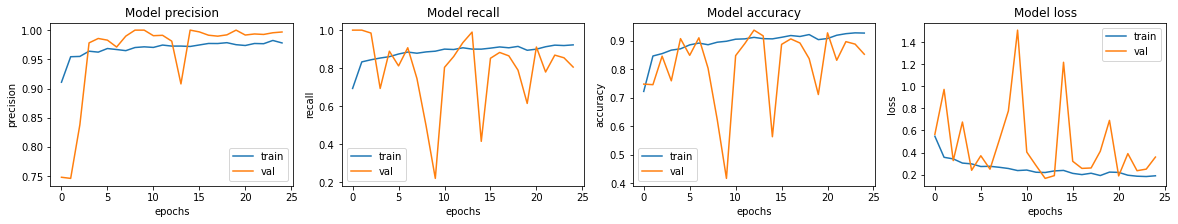

In [40]:
# Data Augmment history
train_result(history.history)

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.2521 - accuracy: 0.8846 - precision: 0.9732 - recall: 0.8385
Loss: 0.25207647681236267,
Accuracy: 0.8846153616905212,
Precision: 0.9732142686843872,
Recall: 0.8384615182876587


- 테스트 데이터셋으로 평가한 결과 88%의 정확도가 나왔다.

## 7-2. 모델 저장 도우미 함수
- 데이터 증강 전 후 모델의 학습 결과를 비교하기 위해 모델 저장, 불러오기 도우미 함수를 만들었다.

In [55]:
def save_model(model_name):
    model_path = ROOT_PATH+f'/chest_xray/saved_model/{model_name}'
    hist_path = ROOT_PATH+f'/chest_xray/history/{model_name}_history.pkl'
    model.save(model_path)
    joblib.dump(history.history, hist_path)

In [60]:
# 데이터 증강을 한 후 모델 저장
save_model('augmodel')

INFO:tensorflow:Assets written to: /aiffel/aiffel/enode11/chest_xray/saved_model/augmodel/assets


In [34]:
def load(model_name):
    new_model = tf.keras.models.load_model( ROOT_PATH+f'/chest_xray/saved_model/{model_name}')
    new_history = joblib.load(ROOT_PATH+f'/chest_xray/history/{model_name}_history.pkl')
    return new_model, new_history

## 7-3. 데이터 증강 전후 학습 결과 비교
- 데이터 증강 전에 비해 확실히 데이터 증강 후의 평가지표가 좋았다.

In [46]:
lms_model, lms_history = load('model1')

In [59]:
print('=================데이터 증강 전=================')
lms_loss, lms_accuracy, lms_precision, lms_recall = lms_model.evaluate(test_ds)
print(f'Loss: {lms_loss},\nAccuracy: {lms_accuracy},\nPrecision: {lms_precision},\nRecall: {lms_recall}')
print('=================데이터 증강 후=================')
aug_loss, aug_accuracy, aug_precision, aug_recall = aug.evaluate(test_ds)
print(f'Loss: {aug_loss},\nAccuracy: {aug_accuracy},\nPrecision: {aug_precision},\nRecall: {aug_recall}')

=================데이터 증강 전=================
39/39 [==============================] - 3s 74ms/step - loss: 0.9874 - accuracy: 0.8494 - precision: 0.8109 - recall: 0.9897
Loss: 0.9874159097671509,
Accuracy: 0.8493589758872986,
Precision: 0.8109243512153625,
Recall: 0.9897435903549194
=================데이터 증강 후=================
39/39 [==============================] - 3s 74ms/step - loss: 0.2658 - accuracy: 0.9022 - precision: 0.8713 - recall: 0.9897
Loss: 0.26578590273857117,
Accuracy: 0.9022436141967773,
Precision: 0.8713318109512329,
Recall: 0.9897435903549194


데이터 증강 전 학습 결과


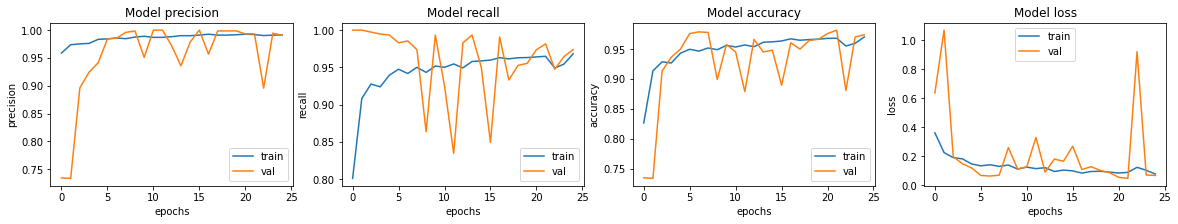

In [67]:
# 데이터 증강 전 학습 과정
print(f'데이터 증강 전 학습 결과')
train_result(lms_history)

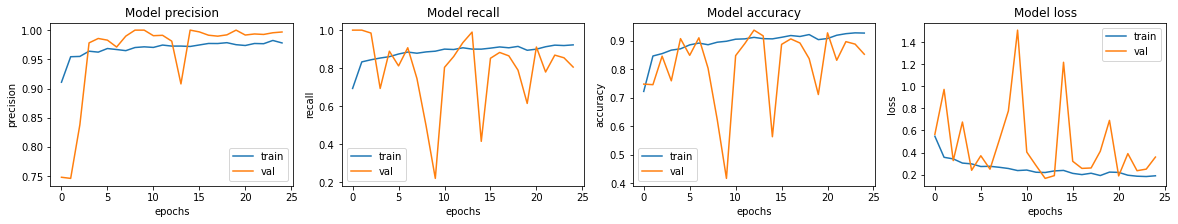

In [40]:
# 데이터 증강 후 학습 결과
train_result(history.history)

- 같은 데이터셋으로 다시 학습을 진행했었는데 역시 차이를 보였다. 그래도 데이터 증강 전보다는 전반적으로 좋은 점수가 나왔다.

데이터 증강 후 학습 결과


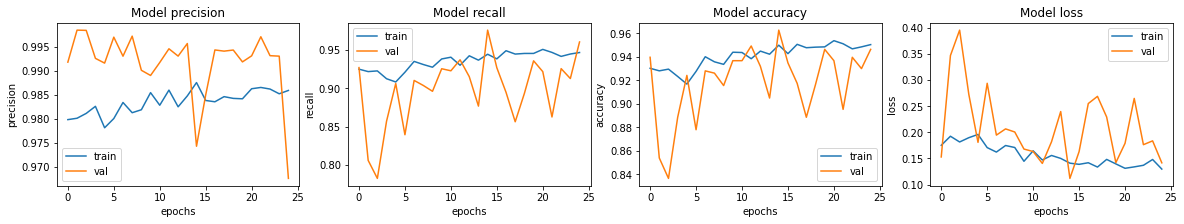

In [101]:
# 데이터 증강 후 학습 과정
print(f'데이터 증강 후 학습 결과')
train_result(aug_history)

# step8) 성능 강화를 위한 Data Augmentation
- step2에 바로 추가하였음.

# 회고
## 이미지 증강 시도
1. 처음에는 `OpenCv`를 사용하고자 했었다. 그러나 배치 사이즈에 맞게 불러올 수 있는 데이터를 리스트에 무작정 담는 것이 비효율적이게 느껴졌다. 전체적인 데이터셋 생성 파이프라인 구조를 유지하면서 사용할 수 있는 방법이 없을지 찾아봤다.
2. 두번째는 텐서플로우에서 기본적으로 제공하는 `tf.keras.preprocessing.image.ImageDataGenerator`를 사용해보고자 했다. 그러나 validation 데이터가 너무 작기도 하고 `ImageDataGenerator`는 말그대로 제네레이터라 전체 데이터 크기를 알 수 없어서 validation step을 지정하는 부분에서 계속 에러가 발생했다. `ImageDataGenerator`에서 제공하는 `flow_from_directory()`를 사용하고 싶었으나 그럴 경우 train과 val 디렉토리를 개인적으로 합쳐야 깔끔한 코드가 나왔다. 원본 데이터 구조는 건드리고 싶지 않아서 다른 방법을 찾기로 했다.
3. 텐서플로우에서 제공하는 산술 함수를 활용한 데이터 증강 방법을 찾았다. 함수형식으로 제공되어서 기존의 `prepare_for_trainig`함수에 적용할 수 있었다

## 궁금증
- 왜 validation accuracy와 loss가 수렴하지 않고 특정 에폭에서 튀는 경향을 보일까?
    - 모델을 바꿔보아도 이런 현상은 지속되었다.
- `BatchNormalization`과 `Dropout`을 연달아서 쓰는 것이 과연 효과적인가?
    - 처음에 `ZeroPadding`을 넣고서 `Conv`+`MaxPooling`+`BatchNormalization` 을 반복한 후에 `Flatten`과 `Dense`를 거치고 마지막에 `Dropout`을 해주는 모델을 사용해보았는데 오히려 더 좋은 성능이 나왔다.
    
## 더 시도해볼 것
- 텐서플로우 `tf.image`에서 제공하는 전처리 함수들 (`tf.image.random_flip_left_right`).. 너무 써보고 싶다. 다른 CV 프로젝트를 할 일이 생기면 사용해보자.
- 어떤 방법이 좋을지 한참 찾다가 공식문서와 좀 친해진 기분이다. 써먹을만한 예제를 정리해서 글을 써봐야겠다.